# Spectral Methods Part III: More Examples of the Discontinuous Galerkin Spectral Element Method

Ernesto Barraza-Valdez, June 24, 2024

This notebook follows *Implementing Spectral Methods for Partial Differential Equations* by Dr. David Kopriva.

This is Part 3. It extends Chapters 8 of Dr. Kopriva's textbook by adding examples of problems with discontinuous boundaries.

In this notebook, you are expected to know some Julia and to follow along the book. 
Because Julia has many useful libraries and packages for linear algebra (such as BLAS) and fourier transforms (such as FFTW) we will put those to use in order to focus more on advanced methods for non-periodic problems. 

In [1]:
#Check if Julia is working by checking version
VERSION

v"1.10.3"

We will activate a project in order to keep all Julia Packages useful for the rest of the notebooks

In [2]:
] activate .

  Activating project at `/dfs6/pub/ernestob/Julia/git/Implementing-Spectral-Methods`


If you haven't already created the project from the previous notebook uncomment the next code cell and run it. If the project is already created then you can leave it commented

In [3]:
# ] add BenchmarkTools FFTW Test TimerOutputs HDF5 Printf FastGaussQuadrature ApproxFun FastTransforms Polynomials SpecialPolynomials FastChebInterp Latexify Plots LaTeXStrings IncompleteLU Preconditioners IterativeSolvers LinearMaps RecursiveFactorization LinearOperators Krylov IJulia Revise

In [4]:
using FFTW
using Base.Threads
using LinearAlgebra
using SparseArrays
using Test
using TimerOutputs
using HDF5
using Printf
using FastGaussQuadrature
using ApproxFun
using FastTransforms
using FastChebInterp
using Polynomials
using SpecialPolynomials
using BenchmarkTools
using Latexify
using Plots
using LaTeXStrings
using IncompleteLU
using Preconditioners 
using IterativeSolvers
using LinearMaps
using RecursiveFactorization
using LinearOperators
using Krylov
using IJulia
using Revise

# Creating a Julia Package

We need to create a package in Julia to store all our functions from Chapters 1-4. 

We can follow the following links for `Pkg.jl`: 

https://pkgdocs.julialang.org/v1/creating-packages/

and `Revise.jl`

https://timholy.github.io/Revise.jl/stable/

Where `Revise.jl` makes it easy to revise any of the source code of the package.

First we generate a package with the base package of `Pkg.jl`

Notice that in Jupyter we can use the bracket `]` to access `Pkg` mode

If you have not done this, go ahead and uncomment the below cell

In [5]:
# ] generate Part2b

A Part I directory was added. Navigating through it we can access the src directory where we will put the Chapter 1-3 code

Next we need to use a terminal app and open Julia. Navigate to this folder.

Activate a project there and add the packages needed for Chapters 1-3. 

Such as the following steps:

```
$> cd ./Part1
$> julia
```

then in Julia

```
] activate .
```
```
] add BenchmarkTools LinearAlgebra SparseArrays FFTW Test TimerOutputs HDF5 Printf FastGaussQuadrature ApproxFun FastTransforms Polynomials SpecialPolynomials FastChebInterp Latexify Plots LaTeXStrings IncompleteLU Preconditioners IterativeSolvers LinearMaps RecursiveFactorization LinearOperators Krylov IJulia
```

After we paste our code from the previous notebook. 

After doing the above we can import the Part1 package. First we need to add it to the scope

In [6]:
push!(LOAD_PATH, "Part2b/");


Then we just use the `using`

In [7]:
using Part2b

Part 1, and 2a functions are now fully loaded

# Nodal Discontinuous Galerkin Spectral Element Method with Discontinuities 

# Acoustics and Density Discontinuity

As mentioned before, the NDGSEM is a good method for problems with discontinuities. We will follow from the preious notebook with the acoustic equations, however, we will add a discontinuity in the equilibrium density. 

Consider the Acoustic wave equation: 

\begin{align}
    \frac{\partial}{\partial t} \left[ \begin{array}{cc}  
    p \\
    u
    \end{array}\right] + \left[ \begin{array}{cc} 
    0 \:\:\: K_0 \\
    \frac{1}{\rho_{eq}} \:\:\: 0  
    \end{array}\right] \cdot \frac{\partial}{\partial x} \left[ \begin{array}{cc}  
    p \\
    u
    \end{array}\right] = 0
\tag{R0}
\end{align}

However, now we have:

\begin{align}
    \rho_{eq} = \begin{cases}
  \rho_0 & x \lt x_b \\
  \rho_1 & x \gt x_b 
\end{cases}
\end{align}

Where $x_b$ is the boundary where $\rho$ changes

# Reimann Problem and Flux

For this case we need to revisit our Riemann solver from the last notebook.

In the last notebook it was found that eigenvalues of $\underline{A}$ are:

\begin{align}
    \lambda_1 &= c(x) = \sqrt{K_0/\rho(x)} \\
    \lambda_2 &= -c(x)
\tag{R5}
\end{align}

And we defined the *impedance* of the wave as: 

\begin{align}
    Z(x) = K_0 \: \rho(x)
\tag{R12}
\end{align}

In this case, $\rho(x)$ is changing as a function of $x$ and therefore $c(x)$ and $Z(x)$ will change as a function of of $x$

with eigen vectors: 

\begin{align}
    \left[ \begin{array}{cc} 
   K_0\:\rho \\
    1 
    \end{array}\right], \left[ \begin{array}{cc} 
   -K_0\:\rho \\
    1 
    \end{array}\right]
\tag{R6}
\end{align}


Diagonalization Matrices were defined: 

\begin{align}
    \underline{S} = \left[ \begin{array}{cc} 
   K_0\:\rho & -K_0\:\rho \\
    1 & 1 
    \end{array}\right] = \left[ \begin{array}{cc} 
    Z & -Z \\
    1 & 1 
    \end{array}\right]
\end{align}

\begin{align}
    \underline{S}^{-1} = \frac{1}{2}\left[ \begin{array}{cc} 
   \frac{1}{Z} & 1 \\
    -\frac{1}{Z} & 1
    \end{array}\right] 
\end{align}

We also call these the transformation matrices.

and the eigen value matrix is:

\begin{align}
    \underline{\Lambda} = \left[ \begin{array}{cc} 
        c & 0 \\
        0 & -c 
    \end{array}\right]
\tag{R9}
\end{align}

We can split the eigenvalue matrix as a left ($\Lambda^-$) and right ($\Lambda^+$) going eigenvalue matrices as: 

\begin{align}
    \underline{\Lambda}^+ = \left[ \begin{array}{cc} 
    c & 0 \\
    0 & 0
    \end{array}\right]
\tag{R10}
\end{align}

\begin{align}
    \underline{\Lambda}^+ = \left[ \begin{array}{cc} 
    0  & 0 \\
    0 & -c
    \end{array}\right]
\tag{R11}
\end{align}

And we found the flux to be:

\begin{align}
    F^* = \left( \underline{S} \cdot \underline{\Lambda}^{+} \cdot \underline{S}^{-1} +   \underline{S} \cdot\underline{\Lambda}^{-} \cdot \underline{S}^{-1}  \right)  \cdot \bar{q} = \frac{c}{2} \left[ \begin{array}{cc} 
   Z \left( w^+ + w^-  \right) \\
    w^+ - w^-
    \end{array}\right] = \frac{c}{2} \left[ \begin{array}{cc} 
     p^+ + Z(x^+)\: u^+ - p^- + Z(x^-)\: u^-   \\
    \frac{p^+}{Z(x^+)} + u^+ + \frac{p^-}{Z(x^-)} - u^- 
    \end{array}\right]
\tag{R13}
\end{align}

Where $x^{\pm}$ is the position of the right moving or left moving wave which will change the impedance $Z$

With:

This analysis wasn't just useful for the flux. We can also obtain the analytical solution for this problem. To do this we recognize that:

\begin{align}
    w^+ &= \frac{p}{Z(x^+)} + u \\ 
    w^- &= -\frac{p}{Z(x^-)} + u
\tag{R14}
\end{align}

and the analytical solution of:


\begin{align}
    \bar{q} = \left[ \begin{array}{cc} 
    p \\
    u
    \end{array}\right]  = \left[ \begin{array}{cc} 
    \frac{1}{2} \left(  2^{ -\frac{(x -c(x) t -1)^2}{b^2}} + 2^{ -\frac{(x + c(x) t -1)^2}{b^2}}  \right)  \\
    \frac{1}{2} \left(  2^{ -\frac{(x -c(x) t -1)^2}{b^2}} - 2^{ -\frac{(x + c(x)t -1)^2}{b^2}}  \right)
    \end{array}\right] 
\end{align}


# Implementation

We will again start with  a struct to hold all of our simulation information. If you are a bit confused that is ok. Please review the previous notebooks or ask for help on github.

In [8]:
mutable struct DGSEM1D

    N::Vector{Int64}
    K::Int64
    Neqn::Int64
    xi::AbstractArray #node locations
    wk::AbstractArray #Gauss-Lobatto quad weights
    wbk::AbstractArray #Barycentric weights
    xk::Array{Float64} #Element Boundary Locations
    dxk::Array{Float64} #Element sizes
    xkL::Array{Float64} #left boundary of elements
    xkR::Array{Float64} #Right boundary of elements
    Q::AbstractArray{Float64} #Solution, 2D matrix with (j,k) where j are nodes and k are element
    dQ::AbstractArray{Float64} #right hand side, 2D matrix with (j,k) where j are nodes and k are element
    G::AbstractArray{Float64} #Low Storage RK3
    QLint::Array{Float64} # solution at left element boundaries
    QRint::Array{Float64} #solution at right element boundaries
    QLext::Array{Float64} # solution at left element boundaries
    QRext::Array{Float64} #solution at right element boundaries
    F::AbstractArray{Float64} #flux
    dF::AbstractArray{Float64} 
    FR::Array{Float64} #numerical flux on the right of elements
    FL::Array{Float64} #numerical flux on left of elements

    Dhat::AbstractArray #First derivative matrix in x
    c::AbstractArray #speed of wave
    rho::AbstractArray
    Kbulk::AbstractArray
    Z::AbstractArray
    n::Vector{Float64} #Normal Vector
    
    lp1::AbstractArray #langrange interpolation at x=1 boundary
    ln1::AbstractArray #langrange interpolation at x=-1 boundary
    DGSEM1D() = new()

end


In [9]:
#seperate struct for element boundary pointers
mutable struct EPKD

    eleft::AbstractArray{Int64}
    eright::AbstractArray{Int64}
    nodeleft::AbstractArray{Int64}
    noderight::AbstractArray{Int64}

end

Because we can't erase or rename structs when we change them we need to do a trick:

In [10]:
DGSEM = DGSEM1D

DGSEM1D

In [11]:
#alg 59B
#NodalDiscontinuousGalerkinConstruct
function NDGConstruct(NDG::DGSEM, N::Vector{Int64}, K::Int64, LegOrCheb::String, Nvec::Int64, Func::AbstractArray, kvec::Array{Float64}, t::Float64,  xk::AbstractArray)
    #Inputs
    #NDGsystem - Struct containing all variables needed
    #N - Number of nodes from 0 to N in x-direction
    #M - Number of nodes from 0 to M in y-direction

    #set node points
    NDG.N = N
    NDG.K = K
    #wave variables
    # NDG.c = c
    NDG.n = kvec
    # NDG.rho = rho
    # NDG.Kbulk = Kbulk
    #total number of equations of vector
    NDG.Neqn = Nvec
    #total number of points on grid
    Ntot = sum(N)+K
    #Ntot = K*(N+1)

    
    xi = []
    wk = []
    wkb = []
    for k in 1:K
        x, w = LegendreGaussNodesAndWeights(N[k], 100000, 1e-9)
        wb = BarycentricWeights(x)
        push!(xi, x)
        push!(wk,w)
        push!(wkb, wb)
        
        
    end

    NDG.xi = xi #[x[j] for j in 1:N+1, k in 1:K]
    NDG.wk = wk #[w[j] for j in 1:N+1, k in 1:K];
    NDG.wbk = wkb #[wb[j] for j in 1:N+1, k in 1:K];

    #calculate element domains
    NDG.xk = xk
    #set up full domain in real x
    #domain is from [-8,8] with a total of N*K nodes and K elements
    #set element domains
    dxk = zeros(Float64,K)
    avxk = zeros(Float64,K)
    for k in 1:K
        avxk[k] = xk[k+1] + xk[k]
        dxk[k] = xk[k+1] - xk[k]

    end
    #set dxk
    NDG.dxk = dxk
   
    
    #interpolation coefficients for l_j(+-1)
    ln1 = []
    lp1 = []
    for k in 1:K
        push!(ln1, LagrangeInterpolatingPolynomials(-1.0, xi[k],wkb[k],1.0e-12))
        push!(lp1, LagrangeInterpolatingPolynomials(1.0, xi[k],wkb[k],1.0e-12))
    end
    
    NDG.ln1 = ln1 #LagrangeInterpolatingPolynomials(-1.0, x,wb,1.0e-12)
    NDG.lp1 = lp1 #LagrangeInterpolatingPolynomials(1.0, x, wb,1.0e-12)

    #derivative matrix
    # Dx = PolynomialDerivativeMatrix(x)
    # NDG.Dhat = zeros(Float64, (size(Dx),K))
    Dhat = []

    for k in 1:K
        Dx = PolynomialDerivativeMatrix(xi[k])
        Dh = zeros(Float64, size(Dx))
        for j in 0:N[k]
            jj=j+1
            for i in 0:N[k]
                ii = i+1 
                Dh[ii,jj] = -Dx[jj,ii]*wk[k][jj]/wk[k][ii]
            end
        end
        push!(Dhat, Dh)
    end

    NDG.Dhat = Dhat;

    # for k in 2:K
    #     @. NDG.Dhat[:,:,k] = NDG.Dhat[:,:,1]
    # end

    #setting up initial conditions
    #calculate real positions
    #from affine map
    xreal = zeros(Float64, Ntot)
    for k in 1:K
        for j in 1:N[k]+1
            n = j + (k-1)*(N[k]+1)
            xreal[n] = dxk[k]/2.0*xi[k][j] + avxk[k]/2.0

        end

    end

    NDG.Q = zeros(Float64, (Ntot, Nvec))
    for n in 1:Nvec
        NDG.Q[:,n] = Func[n].(xreal,t)
    end
    # NDG.Q = Fp.(xreal, t)#zeros(Float64, ((N+1),(M+1)))
    NDG.dQ = zeros(Float64, size(NDG.Q))
    NDG.G = zeros(Float64, size(NDG.Q))

    NDG.F =zeros(Float64, (maximum(N)+1, Nvec))
    NDG.dF = zeros(Float64, (maximum(N)+1, Nvec))
    

    NDG.FR = zeros(Float64,(Nvec, K))
    NDG.FL = zeros(Float64,(Nvec,K))

    NDG.QRint = zeros(Float64, (Nvec,K))
    NDG.QRext = zeros(Float64, Nvec) #there's only one exteral point
    NDG.QLint = zeros(Float64, (Nvec,K))
    NDG.QLext = zeros(Float64,Nvec) # there's only one external point

    

    return xreal

end

NDGConstruct (generic function with 1 method)

In [12]:
#alg 61a
function InterpolateToBoundaryDGSEM1D!(Phi::Array{Float64}, Lj::Array{Float64})

    N = length(Phi)
    interpolatedValue = 0.0

    # for j in 0:N-1
    #     jj=j+1
    #     interpolatedValue = interpolatedValue + Phi[jj]*Lj[jj]
    # end
    interpolatedValue = sum(Phi.*Lj)

    return interpolatedValue
end



InterpolateToBoundaryDGSEM1D! (generic function with 1 method)

In [13]:
#Alg 92
#using eqn 5.152
function SystemDGSEMDerivative!(N::Int64, Neqn::Int64, dF::AbstractArray, F::AbstractArray, Dhat::AbstractArray, w::Array{Float64}, lp1::Array{Float64}, ln1::Array{Float64}, FL::Array{Float64}, FR::Array{Float64})
    #construct flux derivative
    
    for n in 1:Neqn 
        dF[:, n] .= Dhat * F[:,n]
    
        @. dF[:,n] =  dF[:,n] + (FR[n]*lp1  + FL[n]*ln1)/w
    end

    return nothing


end

SystemDGSEMDerivative! (generic function with 1 method)

In [14]:
#alg 93
function DGSEM1DGlobalTimeDerivative!(NDG::DGSEM, pk::EPKD, t::Float64,  eindex::Array{Int64}, ExternalState::Function, ReimannSolver::Function, flux::Function)


    N = NDG.N
    K = NDG.K
    Neqn = NDG.Neqn

    Q = @view(NDG.Q[:,:])
    # println("Size of Q: ", size(Q))
    # println("Starting Boundary Element Interpolation")
    for k in 1:K
        #left boundary index
        lpoint = eindex[2*k-1]
        #right boundary index
        rpoint = eindex[2*k]
        # println("k: ", k)
        # println("Left:Right index: ", lpoint, ":", rpoint)
        for n in 1:Neqn
            
            NDG.QLint[n,k] = InterpolateToBoundaryDGSEM1D!(Q[lpoint:rpoint,n], NDG.ln1[k])
            NDG.QRint[n,k] = InterpolateToBoundaryDGSEM1D!(Q[lpoint:rpoint,n], NDG.lp1[k])
        end
    end
    # println("Starting External State")
    #ExternalState must return a vector size 3 which are the external values at the boundary
    #k <- p0.eright = 1
    k=1
    NDG.QLext[:] .= ExternalState(NDG.QLint[:,k], -1.0, NDG.xk[1], t, "LEFT")
    k=K
    NDG.QRext[:] .= ExternalState(NDG.QRint[:,k], 1.0, NDG.xk[end], t, "RIGHT")

    # println("Starting ReimannSolver")
    for k in 0:K
        kk=k+1
        #left boundary index
        idL = pk.eleft[kk]
        # lpoint = eindex[2*kk-1]
        #right boundary index
        idR = pk.eright[kk]
        # rpoint = eindex[2*k]

        if idL==-1
            lpoint = eindex[1]
            rpoint = eindex[1]
            c = [NDG.c[lpoint], NDG.c[rpoint]]
            rho = [NDG.rho[lpoint], NDG.rho[rpoint]]
            Kbulk = [NDG.Kbulk[lpoint], NDG.Kbulk[rpoint]]
            Z = [NDG.Z[lpoint], NDG.Z[rpoint]]
            #c::AbstractArray, kbulk::AbstractArray, rho::AbstractArray, Z::AbstractArray
            NDG.FL[:,idR] .= ReimannSolver(NDG.QLext, NDG.QLint[:,idR], -1.0, c, Kbulk, rho, Z)
        elseif idR == -1
            lpoint = eindex[end]
            rpoint = eindex[end]
            c = [NDG.c[rpoint], NDG.c[rpoint]]
            rho = [NDG.rho[lpoint], NDG.rho[rpoint]]
            Kbulk = [NDG.Kbulk[lpoint], NDG.Kbulk[rpoint]]
            Z = [NDG.Z[lpoint], NDG.Z[rpoint]]
            NDG.FR[:,idL] .= ReimannSolver(NDG.QRint[:,idL], NDG.QRext,  1.0, c, Kbulk, rho, Z)
        else
            lpoint = eindex[2*kk-1]
            rpoint = eindex[2*k]
            c = [NDG.c[lpoint], NDG.c[rpoint]]
            rho = [NDG.rho[lpoint], NDG.rho[rpoint]]
            Kbulk = [NDG.Kbulk[lpoint], NDG.Kbulk[rpoint]]
            Z = [NDG.Z[lpoint], NDG.Z[rpoint]]
            NDG.FR[:,idL] .= ReimannSolver(NDG.QRint[:,idL], NDG.QLint[:,idR], 1.0, c, Kbulk, rho, Z)
            NDG.FL[:,idR] .= -NDG.FR[:,idL] #ReimannSolver(NDG.QRint[:,idL], NDG.QLint[:,idR], -1.0, [NDG.rho, NDG.Kbulk], NDG.c)
        end
        
    end
    
    # println("Starting Numerical Flux and System Derivative")

    for k in 1:K
        #left boundary index
        lpoint = eindex[2*k-1]
        #right boundary index
        rpoint = eindex[2*k]
        
        #XFlux
        @. NDG.F = 0.0
        flux(NDG.F, NDG.Q, NDG.N[k], lpoint, rpoint, NDG.n, NDG.rho[lpoint:rpoint], NDG.c[lpoint:rpoint])
        # NDG.F[lpoint:rpoint,:] .= flux
        @. NDG.dF= 0.0
        SystemDGSEMDerivative!(NDG.N[k], NDG.Neqn, NDG.dF, NDG.F,NDG.Dhat[k], NDG.wk[k], NDG.lp1[k], NDG.ln1[k], NDG.FL[:,k], NDG.FR[:,k])

        
        NDG.dQ[lpoint:rpoint, :] .= -2.0*NDG.dF/NDG.dxk[k]
            
        
    end
    
    # SystemDGDerivative!(NDG.N, NDG.dF1[:,jj], NDG.dF2[:,jj], NDG.dF3[:,jj], NDG.F1[:,jj], NDG.F2[:,jj], NDG.F3[:,jj], NDG.Dhatx, NDG.wx, NDG.lp1x, NDG.ln1x, FstarL1, FstarL2, FstarL3, FstarR1, FstarR2, FstarR3)
    # SystemDGDerivative!(NDG.N, @view(NDG.dFx[:,1]), @view(NDG.dFx[:,2]), @view(NDG.dFx[:,3]), @view(NDG.Fx[:,1]), @view(NDG.Fx[:,2]), @view(NDG.Fx[:,3]), NDG.Dhatx, NDG.wx, NDG.lp1x, NDG.ln1x, NDG.FL, NDG.FR)

    # NDG.dQ1[:,jj] .= -1.0*NDG.dFx[:,1]
    # NDG.dQ2[:,jj] .= -1.0*NDG.dFx[:,2]
    # NDG.dQ3[:,jj] .= -1.0*NDG.dFx[:,3]



    
end

DGSEM1DGlobalTimeDerivative! (generic function with 1 method)

In [15]:
#alg 62
function DGSEMstep1DRK3!(NDG::DGSEM, pk::EPKD, tn::Float64, dt::Float64, eindex::Array{Int64}, ExternalState::Function, ReimannSolver::Function, flux::Function)

    N = NDG.N
    K = NDG.K
    Neqn = NDG.Neqn
    
    am = [0.0; -5.0/9.0; -153.0/128.0]
    bm = [0.0; 1.0/3.0; 0.75]
    gm = [1.0/3.0; 15.0/16.0; 8.0/15.0]
    t = 0.0
    #N = length(Phi)
    #Phij = copy(Phi)
    #DPhi = zeros(Float64, size(Phi))
    #G = zeros(Float64, size(Phi))
    # @. NDG.G = 0.0

    for m in 1:3
        t = tn +bm[m]*dt #update time
        #gt = g(t) #boundary condition in time
        #time derivative
        DGSEM1DGlobalTimeDerivative!(NDG, pk, t,  eindex, ExternalState, ReimannSolver, flux)
        # @. G = am[m]*G + DPhi
        @. NDG.G = am[m]*NDG.G + NDG.dQ
        #@. Phi = Phi + gm[m] *dt *G
        @. NDG.Q = NDG.Q + gm[m] *dt *NDG.G

    end

    #dirichlet boundary conditions
    # Phi[1] = 0.0
    # Phi[end] = 0.0

    return nothing

end

DGSEMstep1DRK3! (generic function with 1 method)

In [16]:
#alg 51d
function LegendreNDG1DWave!(NDG::DGSEM, pk::EPKD, NT::Int64, dt::Float64, Nout::Int64, eindex::Array{Int64}, ExternalState::Function, ReimannSolver::Function, flux::Function)

    #dt = Ttot/NT
    #N = Int(length(Phi)) - 1
    tn = 0.0
    
    for n in 0:NT-1
        IJulia.clear_output(true)
        println("Time Step: ",n)
        
        @. NDG.G = 0
        @. NDG.dQ = 0

        # DGStepByRK3!(Phi, w, Dhat,g, lp1, ln1, tn, dt, c)
        DGSEMstep1DRK3!(NDG, pk, tn, dt, eindex, ExternalState, ReimannSolver, flux)
        tn = (n+1)*dt
        
        
    end

    return nothing
    
end

LegendreNDG1DWave! (generic function with 1 method)

## 8.1.6 Benchmarking NDG SEM With Discontinuous Density



We will model the same equation as the previous notebook.

Initialize the DGSEM struct

In [17]:
DGSEM = DGSEM1D

DGSEM1D

In [18]:
dsem = DGSEM()

DGSEM1D(#undef, 0, 0, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef)

In [19]:
#set our parameters
#initial time
t0 = 0.0
#position of density discontinuity
xmat = 3.0
#density in left region
rho0 = 1.0
#density in right region
rho1 = 0.75
#bulk modulus in left region
Kbulk0 = 1.0
#bulk modulus in right region
Kbulk1 = 1.00
#sound speed in left region
c0 = sqrt(Kbulk0/rho0)
#sound speed in right region
c1 = sqrt(Kbulk1/rho1)
#impedance in left region
z0 = sqrt(rho0*Kbulk0)
#impedence in right region
z1 = sqrt(rho1*Kbulk1)

#initial position of pressure pulse
X0 = 1.5
#frequency of pulse for CFS condition
omega = c0*1.00
#pulse width
b = 0.15
#normal vector in the x-direction can be -1 or 1
kvec = [1.0, -1.0];


In [20]:
#create a function for the speed at different regions of domain according to the density
function speedc(x, xm=xmat)
    if x <=xm
        return c0
    elseif x>xm
        return c1
    end
end

#Create our Analytical Functions
Fp(x,t) = 0.5(2^(-((x-X0) - speedc(x)*t)^2/b^2) + 2^(-((x-X0) + speedc(x)*t)^2/b^2))
Fu(x,t) = 0.5/rho0/speedc(x)*(2^(-((x-X0) - speedc(x)*t)^2/b^2) - 2^(-((x-X0) + speedc(x)*t)^2/b^2))
#store these function in an array for the struct
Fun = [Fp, Fu]

2-element Vector{Function}:
 Fp (generic function with 1 method)
 Fu (generic function with 1 method)

In [21]:
#simulation domain from  0 to 5
xtot = [0.0, 5.0]
#two total equations
Nvec = 2
#number of elements
K = 10
#number of nodes in each element
NN = 30
#store all nodes of each element in an array
N = [NN for i in 1:K]
#calculate total number of nodes
Ntot = sum(N.+1)
#calculate length of each element
dxk = (xtot[2]-xtot[1])/K
#find start and end of each element
xk = [dxk*i for i in 0:K];

In [22]:
#Construct our NDGSEM struct with parameters and initial conditions
xreal = NDGConstruct(dsem, N, K, "leg", Nvec, Fun,   kvec, t0,  xk);

In [23]:
#set up arrays to hold the sound speed at each position (node)
c = zeros(Float64, length(xreal))
#set up array to hold density at each position (node)
rho = zeros(Float64, length(xreal))
#set up array to hold each bulk modulus at each position (node)
kbulk = zeros(Float64, length(xreal))
#set up array to hold each impedance at each position (node)
Z = zeros(Float64, length(xreal))

for i in 1:length(xreal)
    if xreal[i] <= xmat #if in left region
        rho[i] = rho0
        kbulk[i] = Kbulk0
        c[i] = c0
        Z[i] = z0
    elseif xreal[i] > xmat #if in right region
        rho[i] = rho1
        kbulk[i] = Kbulk1
        c[i] = c1
        Z[i] = z1
    end
end

In [24]:
#input arrays into the struct
dsem.c = c
dsem.rho = rho
dsem.Kbulk = kbulk
dsem.Z = Z;

Let's plot our struct's initial condition with the analytical 

In [25]:
xx = [0.0 + i*5.0/100 for i in 0:100]
pana0 = Fp.(xx,0.0);
#p00 = Fp.(xx,0.0);
uana0 = Fu.(xx,0.0);
p0 = Fp.(xreal,0.0);
u0 = Fu.(xreal,0.0);

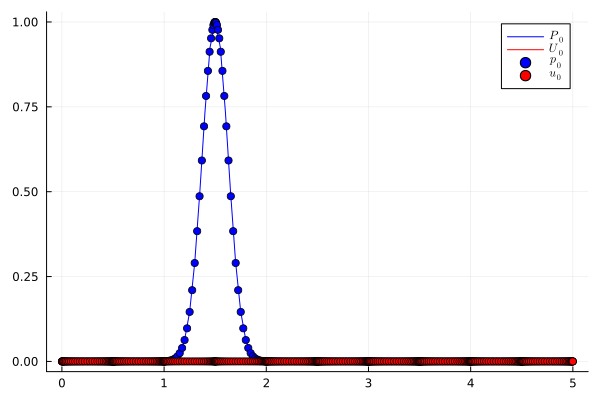

In [26]:
# plot(xx, uana0, color=:blue,label=L"U_0", format=:png)
# plot!(xreal,u0, color=:blue,seriestype=:scatter,label=L"u_0", format=:png)
plot(xx, pana0, color=:blue,label=L"P_0", format=:png)
plot!(xx, uana0, color=:red,label=L"U_0", format=:png)
#plot!(xx, p00, color=:orange,label=L"P_{00}", format=:png)
plot!(xreal,dsem.Q[:,1], color=:blue,seriestype=:scatter,label=L"p_0", format=:png)
plot!(xreal,dsem.Q[:,2], color=:red,seriestype=:scatter,label=L"u_0", format=:png)

In [27]:
#element real location boundaries
#xk

In [28]:
#create elements index locations in 1D array
elindex = zeros(Int64, K*2)
elindex[1] = 1
for k in 1:K-1
    elindex[2*k] = elindex[2*k-1] + N[k]
    elindex[2*k+1] = elindex[2*k]+1
end
elindex[end] = K*(N[end]+1);

Let's check out which indices (nodes) belong to each element:

In [29]:
# for k in 1:K
#     #left boundary index
#     lpoint = elindex[2*k-1]
#     #right boundary index
#     rpoint = elindex[2*k]
#     println(lpoint,":", rpoint)
# end

In [30]:
#Riemann Solver
#alg 88 NDG::NDG2DWaves
function ReimannSolverNDG1D(QL::AbstractArray, QR::AbstractArray, normal::Float64, c::AbstractArray, kbulk::AbstractArray, rho::AbstractArray, Z::AbstractArray)

    cL = c[1]
    cR = c[2]
    rhoL = rho[1]
    rhoR = rho[2]
    kbulkL = kbulk[1]
    kbulkR = kbulk[2]
    ZL = rhoL*cL#/(rhoL*cL + rhoR*cR)#Z[1]#sqrt(n[1]*n[2])
    ZR = rhoR*cR#/(rhoL*cL + rhoR*cR)
    # #Zinv = 1.0/Z #nk2 = n[1]/2.0#*k[1]##*
    
    pL = QL[1]
    pR = QR[1]
    uL = QL[2]
    uR = QR[2]

    F1 = normal*(ZR*cL*(pL+ZL*uL) - ZL*cR*(pR-ZR*uR))/(ZR+ZL) #normal*c/2.0*(pplus + Z*uplus - pminus + Z*uminus)
    F2 = normal*(cL * (pL+ZL*uL) + cR* (pR-ZR*uR) )/(ZR+ZL)   #normal*c/2.0*(pplus + uplus + pminus - uminus)#normal*c/2.0*(Zinv*pplus + uplus + Zinv*pminus - uminus)

    return [F1, F2]
end

ReimannSolverNDG1D (generic function with 1 method)

In [31]:
#alg 64
function FluxAcoustic(F::AbstractArray, Q::AbstractArray, N::Int64, lpoint::Int64, rpoint::Int64, n::AbstractArray, rhobulk::AbstractArray, c::AbstractArray)

    F[:,1] = rhobulk .* c.^2 .* Q[lpoint:rpoint, 2]#c^2 * Q[lpoint:rpoint, 2]#rhobulk[2] * Q[lpoint:rpoint, 2]
    F[:,2] = 1.0./ rhobulk .* Q[lpoint:rpoint, 1]#Q[lpoint:rpoint, 1] #1.0/rhobulk[1] * Q[lpoint:rpoint, 1]

    return nothing #F1, F2

end


FluxAcoustic (generic function with 1 method)

In [32]:
#alg 122 for boundary pointers
#create boundary pointers
eleft = append!([-1],[k for k in 1:K])
eright = append!([k for k in 1:K], [-1])
nodeleft = [Ntot for k in 1:K-1]
noderight = [0 for k in 1:K-1];
epk = EPKD(eleft, eright, nodeleft, noderight);

In [33]:
# epk.eleft

In [34]:
# epk.eright

In [35]:
#external function
# ExternalState(NDG.QLint[:,k], -1.0, NDG.xk[1], t, "LEFT")
function ExtFunFreePropagationAcoustic(Qint::Array{Float64}, xyBoundary::Float64, xy::Float64, t::Float64, LRTB::String)

    neqn=length(Qint)
    Qext = zeros(Float64, neqn)
    
    if LRTB=="LEFT" #|| LRTB== "RIGHT"
        Qext[1] = 0.0#Qint[1]#Fp(xy,t)## #Fp(xy,t)
        Qext[2] = 0.0#-Qint[2]#Fu(xy,t)#Fu(xy,t)# #Fu(xy,t)
        # Qext[3] = Fv(xyBoundary,xy,t)
    elseif LRTB=="RIGHT"
        Qext[1] = 0.0#0.0#Qint[1]#Fp(xy,t) #Fp0(xy,t)
        Qext[2] = 0.0#0.0#-Qint[2]#Fu(xy,t)#Fu0(xy,t)

    end
    return Qext
end

ExtFunFreePropagationAcoustic (generic function with 1 method)

In [36]:
# CFT Number
ddxx = 5.0/(Ntot - K)
CFT = 1.0
ddtt = CFT/c1*ddxx


0.014433756729740645

In [37]:
dsema = deepcopy(dsem)
dt = 1.0e-3
ttot = 2.25
NT = floor(Int64, ttot/dt)


2250

In [41]:
tn = 0.0
for n in 0:NT

    if mod(n,20)==0
        IJulia.clear_output(true)
        println("Time Step: ",n)
    end
    
    @. dsema.G = 0
    @. dsema.dQ = 0

    # DGStepByRK3!(Phi, w, Dhat,g, lp1, ln1, tn, dt, c)
    DGSEMstep1DRK3!(dsema, epk, tn, dt, elindex, ExtFunFreePropagationAcoustic, ReimannSolverNDG1D, FluxAcoustic)
    tn = (n+1)*dt
    
    
end

Time Step: 2240


In [42]:
pt = Fp.(xx,dt*(NT+1))
ut = Fu.(xx,dt*(NT+1));

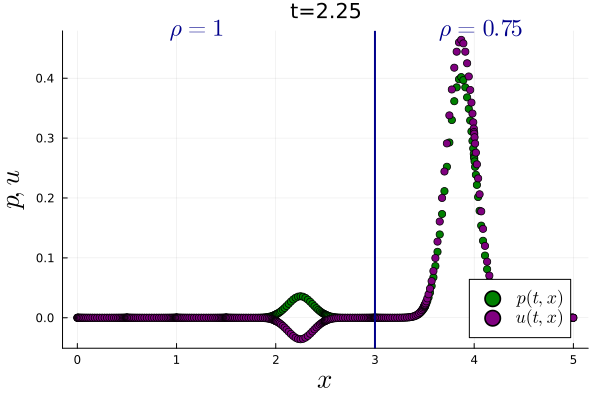

In [43]:
# plot(xx, pt, color=:blue,label=L"P_t", format=:png)
# plot!(xx, ut, color=:red,label=L"U_t", format=:png)
# plot!(xreal,dsem.Q[:,1], color=:blue,seriestype=:scatter,label=L"p_t", format=:png)
plot(xreal,dsema.Q[:,1], color=:green,seriestype=:scatter,label=L"p(t,x)", format=:png)
plot!(xreal,dsema.Q[:,2], color=:purple,seriestype=:scatter,label=L"u(t,x)", format=:png)
vline!([3], color=:darkblue, linewidth=2, label="")
annotate!(1.5, 0.48, text(L"\rho = 1", :darkblue, :right, 16))
annotate!(4.5, 0.48, text(L"\rho = 0.75", :darkblue, :right, 16))
plot!(title="t=2.25", legend=:bottomright, legendfontsize=12)
xlabel!(L"x", guidefont=18)
ylabel!(L"p,u", guidefont=18)

# Maxwell's Equations

\begin{align}
    &\bar{D} = \epsilon(x) \bar{E} \\
    &\bar{H} = \frac{1}{\mu(x)} \bar{B} \\
    &\frac{\partial}{\partial t} \bar{D} + \bar{J}_f = \bar{\nabla}\times \bar{H} \\ 
    -&\frac{\partial}{\partial t} \bar{B}  = \bar{\nabla}\times \bar{E}
\tag{S0}
\end{align}

In 1D with wave travelling in the x-direction and E-field in y-direction, H-field in the z-direction: 

\begin{align}
    & D_y = \epsilon(x) E_y \\
    & H_z = \frac{1}{\mu(x)} B_z \\
    &\frac{\partial}{\partial t} D_y  = \frac{\partial}{\partial x} H_z\\ 
    -&\frac{\partial}{\partial t} B_z  = \frac{\partial}{\partial x} E_y
\tag{S1}
\end{align}

we can re-write this in vector-matrix notation

\begin{align}
    \left[ \begin{array}{cc} 
    \epsilon(x) && 0 \\
    0 && \mu(x)
    \end{array}\right]\cdot \frac{\partial}{\partial t} \left[ \begin{array}{cc} 
    E_y \\
    H_z
    \end{array}\right]   + \left[ \begin{array}{cc} 
   0 && 1 \\
    1 && 0
    \end{array}\right] \cdot \frac{\partial}{\partial x} \left[ \begin{array}{cc} 
    E_y \\
    H_z
    \end{array}\right] = 0
\tag{S2}
\end{align}

or 

\begin{align}
    \left[ \begin{array}{cc} 
    1 && 0 \\
    0 && 1
    \end{array}\right]\cdot \frac{\partial}{\partial t} \left[ \begin{array}{cc} 
    E_y \\
    H_z
    \end{array}\right]   + \left[ \begin{array}{cc} 
   0 && \frac{1}{\epsilon(x)} \\
    \frac{1}{\mu(x)} && 0
    \end{array}\right] \cdot \frac{\partial}{\partial x} \left[ \begin{array}{cc} 
    E_y \\
    H_z
    \end{array}\right] = 0
\tag{S3}
\end{align}

Which can be re-written as:

\begin{align}
    \underline{Q} \frac{\partial }{\partial t} \bar{q} + \underline{A} \frac{\partial }{\partial x} \bar{q} = 0
\tag{S4}
\end{align}


The Flux is given by $\underline{A}\cdot \bar{q}$

The relative permativity is written as:

\begin{align}
    \epsilon_r(x) &= \frac{\epsilon(x)}{\epsilon_0}\\
    &\Rightarrow  \epsilon(x) = \epsilon_0\cdot \epsilon_r(x)
\tag{S5}
\end{align}

and similarly for $\mu(x)$

We will abosrb the vacuum constants into the E-field and H-Field:

\begin{align}
    E_y &\Rightarrow \epsilon_0 E_y \\
    H_z &\Rightarrow \mu_0 H_z
\tag{S6}
\end{align}

We will model a problem that is similar to the Acoustic equations

## Rankine Hugoniot Condition

For this section, we follow Chapter 2.4 in:

- Hesthaven, J. S., & Warburton, T. (2007). Nodal discontinuous Galerkin methods: algorithms, analysis, and applications. Springer Science & Business Media.

For a partial differential equation given by:

\begin{align}
    \underline{\mathbf{Q}} \: \partial_t \mathbf{u} + \underline{\mathbf{A}}_1 \partial_x \mathbf{u} + \underline{\mathbf{A}}_2 \partial_y \mathbf{u}  = 0
\end{align}

We write the flux along the normal:

\begin{align}
    \mathbf{\Pi} = \left( \hat{n}_x \underline{\mathbf{A}}_1 + \hat{n}_y \underline{\mathbf{A}}_2   \right)
\end{align}

so that

\begin{align}
    \hat{\mathbf{n}} \cdot \mathbf{\mathcal{F}} = \mathbf{\Pi} \cdot \mathbf{u}
\end{align}


On page 36 of *Hesthaven*, the **Rankine-Hugoniot Condition** is stated as [references 218, 303 in *Hesthaven*]:

\begin{align}
    \forall i : \:\:\: -\lambda_i \underline{\mathbf{Q}} \left[ \mathbf{u}^- - \mathbf{u}^+ \right] + \left[ \left( \mathbf{\Pi} \mathbf{u} \right)^- - \left( \mathbf{\Pi} \mathbf{u} \right)^+ \right]
\tag{S7 }
\end{align}

Which must hold for each wave with eigenvalue $\lambda_i$, where $\mathbf{u}^{\pm}$ are the outgoing and incoming wave.

Because the discontinuity is piecewise we will use the Rankine-Hugoniot condition which is as follows:

\begin{align}
    &\lambda^- \underline{Q}^- \left( \bar{q}^* - \bar{q}^- \right) + \left[ \left(\underline{\Pi} \bar{q}\right)^* -  \left(\underline{\Pi} \bar{q}\right)^-  \right] = 0 \\
    &\lambda^+ \underline{Q}^+ \left( \bar{q}^{**} - \bar{q}^+ \right) + \left[ \left(\underline{\Pi} \bar{q}\right)^{**} -  \left(\underline{\Pi} \bar{q}\right)^+  \right] = 0 
\tag{S8}
\end{align}

with the assumption that the numerical fluxes are the same $\left(\underline{\Pi} \bar{q}\right)^{*} = \left(\underline{\Pi} \bar{q}\right)^{**}$ since we are calculating the flux through a surface. Then:

\begin{align}
    \left( \lambda^+ \underline{Q}^+ + \lambda^- \underline{Q}^-     \right)\left(\underline{\Pi} \bar{q}\right)^* &= 
    \lambda^+ \underline{Q}^+ \left(\underline{\Pi} \bar{q}\right)^- + \lambda^- \underline{Q}^- \left(\underline{\Pi} \bar{q}\right)^+ + c^- c^+ \underline{Q}^- \underline{Q}^+ \left( \bar{q}^- - \bar{q}^+  \right) \\ 
    \left(\underline{\Pi} \bar{q}\right)^* &=  \left( \lambda^+ \underline{Q}^+ + \lambda^- \underline{Q}^- \right)^{-1} \cdot \left( \lambda^+ \underline{Q}^+ \left(\underline{\Pi} \bar{q}\right)^- + \lambda^- \underline{Q}^- \left(\underline{\Pi} \bar{q}\right)^+ + c^- c^+ \underline{Q}^- \underline{Q}^+ \left( \bar{q}^- - \bar{q}^+  \right) \right)
\tag{S9}
\end{align}

where the $+,-$ superscripts denote the outgoing and incoming wave from normal, respectively

Here: $\left(\underline{A} \bar{q}\right)^{*}$ is the numerical flux, $\left(\underline{A} \bar{q}\right)^{\pm}$ is the outgoing and incoming flux and we need to find:

\begin{align}
    \left( \underline{\Pi} \bar{q} \right)^{\pm,*} = \hat{n} \cdot \left(  \underline{A} \bar{q} \right)^{\pm,*} = \hat{n} \cdot \left[ \begin{array}{cc} 
    H_z^{\pm,*} \\
    E_y^{\pm,*}
    \end{array}\right]
\tag{S10}
\end{align}

We then need to find the eigenvalues of the matrix $\underline{A}$

\begin{align}
    \underline{A} = \left[ \begin{array}{cc} 
    0 && \frac{1}{\epsilon_r(x)}  \\
    \frac{1}{\mu_r(x)}  && 0
    \end{array}\right]
\end{align}


With Eigenvalues: 

\begin{align}
    \lambda_1 &= \frac{1}{\sqrt{\mu \: \epsilon}} = c\\
    \lambda_2 &= -c
\end{align}

and the eigenvectors: 

\begin{align}
    \left[ \begin{array}{cc} 
    \sqrt{\mu / \epsilon} \\
    1
    \end{array}\right], \:\:\:  \left[ \begin{array}{cc} 
    -\sqrt{\mu / \epsilon} \\
    1
    \end{array}\right]
\end{align}

and we define the impedance $Z = \sqrt{\mu / \epsilon}$

Then we should find an inversion for the sum of the matrices: $ \lambda^+ \underline{Q}^+ + \lambda^- \underline{Q}^- $ where the $\pm$ represent the outgoing/incoming waves.

\begin{align}
    \lambda^+ \underline{Q}^+ + \lambda^- \underline{Q}^- &= \left[ \begin{array}{cc} 
    c^+ + c^-  && 0 \\
    0 && -c^+ - c^- 
    \end{array}\right] 
\end{align}

Then the inverse becomes:

\begin{align}
     \left( \lambda^+ \underline{Q}^+ + \lambda^- \underline{Q}^- \right)^{-1} = \left[ \begin{array}{cc} 
    \frac{1}{c^+ + c^-} && 0 \\
    0 && -\frac{1}{c^+ + c^-}
    \end{array}\right] 
\end{align}


We then need to find the eigenvalues of the matrix $\underline{Q}^{-1} \underline{A}$

\begin{align}
    \underline{Q}^{-1} = \left[ \begin{array}{cc} 
    \frac{1}{\epsilon(x)} && 0 \\
    0 && \frac{1}{\mu(x)}
    \end{array}\right]
\end{align}

\begin{align}
    \underline{Q}^{-1}\underline{A} = \left[ \begin{array}{cc} 
    0 && \frac{1}{\epsilon(x)}  \\
    \frac{1}{\mu(x)}  && 0
    \end{array}\right]
\end{align}


With Eigenvalues: 

\begin{align}
    \lambda_1 &= \frac{1}{\sqrt{\mu \: \epsilon}} = c\\
    \lambda_2 &= -c
\end{align}

and the eigenvectors: 

\begin{align}
    \left[ \begin{array}{cc} 
    \sqrt{\mu / \epsilon} \\
    1
    \end{array}\right], \:\:\:  \left[ \begin{array}{cc} 
    -\sqrt{\mu / \epsilon} \\
    1
    \end{array}\right]
\end{align}

and we define the impedance $Z = \sqrt{\mu / \epsilon}$

Then we should find an inversion for the sum of the matrices: $ \lambda^+ \underline{Q}^+ + \lambda^- \underline{Q}^- $

\begin{align}
    \lambda^{\pm} &= \left[ \begin{array}{cc} 
    c^{\pm}  && 0 \\
    0 && -c^{\pm}
    \end{array}\right]
\end{align}

\begin{align}
    \underline{Q}^{\pm} &= \left[ \begin{array}{cc} 
    \epsilon^{\pm}  && 0 \\
    0 && \mu^{\pm}
    \end{array}\right]
\end{align}


so then:

\begin{align}
    \lambda^{\pm}\cdot\underline{Q}^{\pm} &= \left[ \begin{array}{cc} 
    c^{\pm} \epsilon^{\pm}  && 0 \\
    0 && -c^{\pm} \mu^{\pm}
    \end{array}\right]
\end{align}


\begin{align}
    \lambda^+ \underline{Q}^+ + \lambda^- \underline{Q}^- &= \left[ \begin{array}{cc} 
    c^+ \epsilon^+ + c^- \epsilon^- && 0 \\
    0 && -c^+ \mu^+ - c^- \mu^-
    \end{array}\right] \\
    &\Rightarrow \left[ \begin{array}{cc} 
    \sqrt{\epsilon^+/\mu^+} + \sqrt{\epsilon^-/\mu^-} && 0 \\
    0 && -\sqrt{\mu^+/\epsilon^+} - \sqrt{\mu^-/\epsilon^-} 
    \end{array}\right] \\
    &\Rightarrow \left[ \begin{array}{cc} 
    1/Z^+ + 1/Z^- && 0 \\
    0 && -Z^+ - Z^-
    \end{array}\right]
\end{align}

Then the inverse becomes:

\begin{align}
     \left( \lambda^+ \underline{Q}^+ + \lambda^- \underline{Q}^- \right)^{-1} = \left[ \begin{array}{cc} 
    \frac{Z^+ Z^-}{Z^+ + Z^-} && 0 \\
    0 && \frac{-1}{Z^+ + Z^-}
    \end{array}\right] 
\end{align}

## Implementation

This section will all be similar to the Acoustics section. There is some things that change to account for Maxwell's equations vs the Euler Acoustic Equations

In [44]:
#need to make a new struct
mutable struct DGmaxwell

    N::Vector{Int64}
    K::Int64
    Neqn::Int64
    xi::AbstractArray #node locations
    wk::AbstractArray #Gauss-Lobatto quad weights
    wbk::AbstractArray #Barycentric weights
    xk::Array{Float64} #Element Boundary Locations
    dxk::Array{Float64} #Element sizes
    xreal::Array{Float64}
    Q::AbstractArray{Float64} #Solution, 2D matrix with (j,k) where j are nodes and k are element
    dQ::AbstractArray{Float64} #right hand side, 2D matrix with (j,k) where j are nodes and k are element
    G::AbstractArray{Float64} #Low Storage RK3
    QLint::Array{Float64} # solution at left element boundaries
    QRint::Array{Float64} #solution at right element boundaries
    QLext::Array{Float64} # solution at left element boundaries
    QRext::Array{Float64} #solution at right element boundaries
    F::AbstractArray{Float64} #flux
    dF::AbstractArray{Float64} 
    FR::Array{Float64} #numerical flux on the right of elements
    FL::Array{Float64} #numerical flux on left of elements
    Qminus::AbstractArray{Float64} #flux
    Qplus::AbstractArray{Float64} #flux

    Dhat::AbstractArray #First derivative matrix in x
    c::AbstractArray{Float64}  #speed of wave in material
    Z::AbstractArray{Float64}  #impedance of wave in material
    epsr::AbstractArray{Float64}  #relative permattivity of material
    mur::AbstractArray{Float64}  #relative permeabiilty in material
    n::Vector{Float64} #Normal Vector
    
    lp1::AbstractArray #langrange interpolation at x=1 boundary
    ln1::AbstractArray #langrange interpolation at x=-1 boundary
    DGmaxwell() = new()

end

In [45]:
DGSEM = DGmaxwell

DGmaxwell

In [46]:
#alg 59B
#NodalDiscontinuousGalerkinConstruct
function NDGConstructMax(NDG::DGSEM, N::Vector{Int64}, K::Int64, LegOrCheb::String, Nvec::Int64, Func::AbstractArray,  kvec::Array{Float64}, t::Float64, xk::AbstractArray)
    #Inputs
    #NDGsystem - Struct containing all variables needed
    #N - Number of nodes from 0 to N in x-direction
    #M - Number of nodes from 0 to M in y-direction

    #set node points
    NDG.N = N
    NDG.K = K
    NDG.n = kvec

    #total number of equations of vector
    NDG.Neqn = Nvec
    #total number of points on grid
    Ntot = sum(N)+K
    #Ntot = K*(N+1)

    
    xi = []
    wk = []
    wkb = []
    for k in 1:K
        x, w = LegendreGaussNodesAndWeights(N[k], 100000, 1e-9)
        wb = BarycentricWeights(x)
        push!(xi, x)
        push!(wk,w)
        push!(wkb, wb)
        
        
    end

    NDG.xi = xi #[x[j] for j in 1:N+1, k in 1:K]
    NDG.wk = wk #[w[j] for j in 1:N+1, k in 1:K];
    NDG.wbk = wkb #[wb[j] for j in 1:N+1, k in 1:K];

    #calculate element domains
    NDG.xk = xk
    #set up full domain in real x
    #domain is from [-8,8] with a total of N*K nodes and K elements
    #set element domains
    dxk = zeros(Float64,K)
    avxk = zeros(Float64,K)
    for k in 1:K
        avxk[k] = xk[k+1] + xk[k]
        dxk[k] = xk[k+1] - xk[k]

    end
    #set dxk
    NDG.dxk = dxk
   
    
    #interpolation coefficients for l_j(+-1)
    ln1 = []
    lp1 = []
    for k in 1:K
        push!(ln1, LagrangeInterpolatingPolynomials(-1.0, xi[k],wkb[k],1.0e-12))
        push!(lp1, LagrangeInterpolatingPolynomials(1.0, xi[k],wkb[k],1.0e-12))
    end
    
    NDG.ln1 = ln1 #LagrangeInterpolatingPolynomials(-1.0, x,wb,1.0e-12)
    NDG.lp1 = lp1 #LagrangeInterpolatingPolynomials(1.0, x, wb,1.0e-12)

    #derivative matrix
    # Dx = PolynomialDerivativeMatrix(x)
    # NDG.Dhat = zeros(Float64, (size(Dx),K))
    Dhat = []

    for k in 1:K
        Dx = PolynomialDerivativeMatrix(xi[k])
        Dh = zeros(Float64, size(Dx))
        for j in 0:N[k]
            jj=j+1
            for n in 0:N[k]
                nn = n+1 
                Dh[jj,nn] = -Dx[nn,jj]*wk[k][nn]/wk[k][jj]
            end
        end
        push!(Dhat, Dh)
    end

    NDG.Dhat = Dhat;

    # for k in 2:K
    #     @. NDG.Dhat[:,:,k] = NDG.Dhat[:,:,1]
    # end

    #setting up initial conditions
    #calculate real positions
    #from affine map
    xreal = zeros(Float64, Ntot)
    # eps = zeros(Float64, Ntot)
    # mus = zeros(Float64, Ntot)
    # c = zeros(Float64, Ntot)
    for k in 1:K
        for j in 1:N[k]+1
            n = j + (k-1)*(N[k]+1)
            xreal[n] = dxk[k]/2.0*xi[k][j] + avxk[k]/2.0
        end

    end

    NDG.xreal = xreal

    NDG.Q = zeros(Float64, (Ntot, Nvec))
    for n in 1:Nvec
        NDG.Q[:,n] = Func[n].(xreal,t)
    end
    # NDG.Q = Fp.(xreal, t)#zeros(Float64, ((N+1),(M+1)))
    NDG.dQ = zeros(Float64, size(NDG.Q))
    NDG.G = zeros(Float64, size(NDG.Q))

    NDG.F =zeros(Float64, (maximum(N)+1, Nvec))
    NDG.dF = zeros(Float64, (maximum(N)+1, Nvec))
    

    NDG.FR = zeros(Float64,(Nvec, K))
    NDG.FL = zeros(Float64,(Nvec,K))

    NDG.QRint = zeros(Float64, (Nvec,K))
    NDG.QRext = zeros(Float64, Nvec) #there's only one exteral point
    NDG.QLint = zeros(Float64, (Nvec,K))
    NDG.QLext = zeros(Float64,Nvec) # there's only one external point
    NDG.Qminus = zeros(Float64, (Nvec,Nvec))
    NDG.Qplus = zeros(Float64, (Nvec,Nvec))

    return xreal

end

NDGConstructMax (generic function with 1 method)

The only other thing we need to change is our global derivative to take into account the change in $\epsilon(x)$

In [47]:
#Alg 92
#using eqn 5.152
function SystemDGSEMDerivative!(N::Int64, Neqn::Int64, dF::AbstractArray, F::AbstractArray, Dhat::AbstractArray, w::Array{Float64}, lp1::Array{Float64}, ln1::Array{Float64}, FL::Array{Float64}, FR::Array{Float64})
    #construct flux derivative
    
    # for n in 1:Neqn 
    #     dF[:, n] .= Dhat * F[:,n]
    
    #     @. dF[:,n] =  dF[:,n] + (FR[n]*lp1  + FL[n]*ln1)/w
    # end
    dF[:, 1] .= Dhat * F[:,1]
    @. dF[:,1] =  dF[:,1] + (FR[1]*lp1  + FL[1]*ln1)/w
    dF[:, 2] .= Dhat * F[:,2]
    @. dF[:,2] =  dF[:,2] + (FR[2]*lp1  + FL[2]*ln1)/w

    return nothing


end

SystemDGSEMDerivative! (generic function with 1 method)

In [48]:
#alg 93
function DGSEM1DGlobalTimeDerivativeMax!(NDG::DGSEM, pk::EPKD, t::Float64,  eindex::Array{Int64}, ExternalState::Function, ReimannSolver::Function, flux::Function)


    N = NDG.N
    K = NDG.K
    Neqn = NDG.Neqn

    Q = @view(NDG.Q[:,:])
    # println("Size of Q: ", size(Q))
    # println("Starting Boundary Element Interpolation")
    for k in 1:K
        #left boundary index
        lpoint = eindex[2*k-1]
        #right boundary index
        rpoint = eindex[2*k]
        # println("k: ", k)
        # println("Left:Right index: ", lpoint, ":", rpoint)
        for n in 1:Neqn
            
            NDG.QLint[n,k] = InterpolateToBoundaryDGSEM1D!(Q[lpoint:rpoint,n], NDG.ln1[k])
            NDG.QRint[n,k] = InterpolateToBoundaryDGSEM1D!(Q[lpoint:rpoint,n], NDG.lp1[k])
        end
    end
    # println("Starting External State")
    #ExternalState must return a vector size 3 which are the external values at the boundary
    #k <- p0.eright = 1
    kkk=1
    NDG.QLext[:] .= ExternalState(NDG.QLint[:,kkk], -1.0, NDG.xk[1], t, "LEFT")
    kkk=K
    NDG.QRext[:] .= ExternalState(NDG.QRint[:,kkk], 1.0, NDG.xk[end], t, "RIGHT")

    # println("Starting ReimannSolver")
    for k in 0:K
        kk=k+1
        #left boundary index
        idL = pk.eleft[kk]
        # lpoint = eindex[2*kk-1]
        #right boundary index
        idR = pk.eright[kk]
        # rpoint = eindex[2*k]

        if idL==-1
            lpoint = eindex[1]
            rpoint = eindex[1]
            c = [NDG.c[lpoint], NDG.c[rpoint]]
            epsr = [NDG.epsr[lpoint], NDG.epsr[rpoint]]
            mur = [NDG.mur[lpoint], NDG.mur[rpoint]]
            Z = [NDG.Z[lpoint], NDG.Z[rpoint]]
            #c::AbstractArray, kbulk::AbstractArray, rho::AbstractArray, Z::AbstractArray
            #ReimannSolverNDG1DRHMax!(QL::AbstractArray, QR::AbstractArray,  normal::Float64, epsr::AbstractArray, mur::AbstractArray, c::AbstractArray, Z::AbstractArray)
            NDG.FL[:,idR] .= ReimannSolver(NDG.QLext, NDG.QLint[:,idR], -1.0, "LEFT",epsr, mur, c, Z)
        elseif idR == -1
            lpoint = eindex[end]
            rpoint = eindex[end]
            c = [NDG.c[rpoint], NDG.c[rpoint]]
            epsr = [NDG.epsr[lpoint], NDG.epsr[rpoint]]
            mur = [NDG.mur[lpoint], NDG.mur[rpoint]]
            Z = [NDG.Z[lpoint], NDG.Z[rpoint]]
            NDG.FR[:,idL] .= ReimannSolver(NDG.QRint[:,idL], NDG.QRext,  1.0, "LEFT",epsr, mur, c, Z)
        else
            lpoint = eindex[2*kk-1]
            rpoint = eindex[2*kk]
            c = [NDG.c[lpoint], NDG.c[rpoint]]
            epsr = [NDG.epsr[lpoint], NDG.epsr[rpoint]]
            mur = [NDG.mur[lpoint], NDG.mur[rpoint]]
            Z = [NDG.Z[lpoint], NDG.Z[rpoint]]
            NDG.FR[:,idL] .= ReimannSolver(NDG.QRint[:,idL], NDG.QLint[:,idR], 1.0, "LEFT", epsr, mur, c, Z)
            NDG.FL[:,idR] .= -1.0 .* NDG.FR[:,idL] #ReimannSolver(NDG.QRint[:,idL], NDG.QLint[:,idR], 1.0, "RIGHT", epsr, mur, c, Z)#-NDG.FR[:,idL] #ReimannSolver(NDG.QRint[:,idL], NDG.QLint[:,idR], -1.0, [NDG.rho, NDG.Kbulk], NDG.c)
        end
        
    end
    
    # println("Starting Numerical Flux and System Derivative")

    for k in 1:K
        #left boundary index
        lpoint = eindex[2*k-1]
        #right boundary index
        rpoint = eindex[2*k]
        
        #XFlux
        @. NDG.F = 0.0
        flux(NDG.F, NDG.Q, NDG.N[k], lpoint, rpoint, NDG.n, NDG.epsr[lpoint:rpoint], NDG.mur[lpoint:rpoint])
        # NDG.F[lpoint:rpoint,:] .= flux
        @. NDG.dF= 0.0
        SystemDGSEMDerivative!(NDG.N[k], NDG.Neqn, NDG.dF, NDG.F,NDG.Dhat[k], NDG.wk[k], NDG.lp1[k], NDG.ln1[k], NDG.FL[:,k], NDG.FR[:,k])

        
        NDG.dQ[lpoint:rpoint, :] .= -2.0.*NDG.dF ./ NDG.dxk[k]
            
        
    end

    
end

DGSEM1DGlobalTimeDerivativeMax! (generic function with 1 method)

In [49]:
# #alg 62
function DGSEMstep1DRK3Max!(NDG::DGSEM, pk::EPKD, tn::Float64, dt::Float64, eindex::Array{Int64}, ExternalState::Function, ReimannSolver::Function, flux::Function)

    N = NDG.N
    K = NDG.K
    Neqn = NDG.Neqn
    
    am = [0.0; -5.0/9.0; -153.0/128.0]
    bm = [0.0; 1.0/3.0; 0.75]
    gm = [1.0/3.0; 15.0/16.0; 8.0/15.0]
    t = 0.0
    #N = length(Phi)
    #Phij = copy(Phi)
    #DPhi = zeros(Float64, size(Phi))
    #G = zeros(Float64, size(Phi))
    # @. NDG.G = 0.0

    for m in 1:3
        t = tn +bm[m]*dt #update time
        #gt = g(t) #boundary condition in time
        #time derivative
        DGSEM1DGlobalTimeDerivativeMax!(NDG, pk, t,  eindex, ExternalState, ReimannSolver, flux)
        # @. G = am[m]*G + DPhi
        @. NDG.G = am[m]*NDG.G + NDG.dQ
        #@. Phi = Phi + gm[m] *dt *G
        @. NDG.Q = NDG.Q + gm[m] *dt *NDG.G

    end

    #dirichlet boundary conditions
    # Phi[1] = 0.0
    # Phi[end] = 0.0

    return nothing

end

DGSEMstep1DRK3Max! (generic function with 1 method)

# Benchmarking

We will benchmark our NDGSEM with an initial pulse similar to our Euler-Acoustic example. 

With an initial values of:

\begin{align}
    E_0 &= e^{ -\frac{(x-x_0)^2}{\tau^2}   } \\
    H_0 &= \frac{E_0}{Z_0} 
\end{align}

The method of Characteristics tells us that $x \rightarrow x(x_0, t) = x_0 + \lambda t$

\begin{align}
    w^+_0 = \frac{1}{2} \left( \frac{E_0}{Z} + H_0  \right)= \frac{1}{Z} e^{ -\frac{(x-x_0)^2}{\tau^2}   }
\end{align}

\begin{align}
    w^+ = w^+_0(x \rightarrow x(x_0, t) = x_0 - c t) = \frac{1}{Z} e^{ -\frac{(x - c t - x_0)^2}{\tau^2}   }
\end{align}

Similarly:

\begin{align}
    w^-_0 = \frac{1}{2} \left( -\frac{E_0}{Z} + H_0  \right) = 0
\end{align}

\begin{align}
    w^- = w^-_0(x \rightarrow x(x_0, t) = x_0 + c t) = 0 =-\frac{1}{2 Z} e^{ -\frac{(x + c t - x_0)^2}{\tau^2}   }
\end{align}



So then the analytical solution is:

\begin{align}
    \bar{q} = \left[ \begin{array}{cc} 
    E_y \\
    H_z
    \end{array}\right]  = \underline{P}\cdot \left[ \begin{array}{cc} 
    w^+ \\
    w^-
    \end{array}\right]  = \left[ \begin{array}{cc} 
    Z && -Z \\
    1 && 1
    \end{array}\right] \cdot  \left[ \begin{array}{cc} 
    w^+ \\
    w^-
    \end{array}\right]  = \left[ \begin{array}{cc} 
    \frac{1}{2} \left(  e^{ -\frac{(x -ct - x_0)^2}{\tau^2}} + e^{ -\frac{(x + ct - x_0)^2}{\tau^2}}  \right)  \\
    \frac{1}{2 Z} \left(  e^{ -\frac{(x -ct - x_0)^2}{\tau^2}} - e^{ -\frac{(x + ct - x_0)^2}{\tau^2}}  \right)
    \end{array}\right] 
\end{align}


We must benchmark with theoretical solution. 

The initial incident waves travelling to the right that hit the interface are: 

\begin{align}
    \tilde{E}_{I0} &= \frac{1}{2} e^{ -\frac{(x -c_0 t - x_0)^2}{\tau^2}} \\
    \tilde{H}_{I0} &= \frac{1}{2 Z}  e^{ -\frac{(x -c_0 t - x_0)^2}{\tau^2}}
\end{align}


On the left, $\epsilon_1 = 1.0$ and on the right $\epsilon_2 = 2.25$ and $\mu_L = \mu_R = 1.0$

When the incident wave hits the interface, a reflected and transmitted wave are created. 

We use the solution given by Griffiths. 

- Griffiths, D. J. (2023). Introduction to electrodynamics. Cambridge University Press.


According to Griffiths, for **Plane Waves** we have:

\begin{align}
    E_R &= \tilde{E}_{R0} \: \: e^{i \left(  k_0 x -\omega_0 t  \right)} \\
    H_R &= -\tilde{H}_{R0} \: \: e^{i \left(  k_0 x -\omega_0 t  \right)} 
\end{align}

and

\begin{align}
    E_T &= \tilde{E}_{T0} \: \: e^{i \left(  k_1 x -\omega_1 t  \right)} \\
    H_T &= \tilde{H}_{T0} \: \: e^{i \left(  k_1 x -\omega_1 t  \right)} 
\end{align}



Where the amplitudes are given by 

\begin{align}
    \tilde{E}_{R0} &= R \cdot \tilde{E}_{I0} \\
    \tilde{H}_{R0} &= \frac{1}{Z_0} \tilde{E}_{R0}
\end{align}

\begin{align}
    \tilde{E}_{T0} &= T \cdot \tilde{E}_{I0} \\
    \tilde{H}_{T0} &= \frac{1}{Z_1} \tilde{E}_{T0}
\end{align}

$R$ and $T$ are the reflection and transmission coefficeints 

Eqn 81 we have: 

\begin{align}
    \beta = \frac{Z_0}{Z_1}
\end{align}

And the amplitudes for the reflected and transmitted waves: 

\begin{align}
    \tilde{E}_{R0} &= \frac{1-\beta}{1+\beta} \tilde{E}_{I0}\\
    \tilde{E}_{T0} &= \frac{2}{1+\beta} \tilde{E}_{I0}
\end{align}

For pulses, the amplitude and pulsewidth is modified for the reflected and transmitted waves. 
We follow: 

**Abhay K. Ram, George Vahala, Linda Vahala, Min Soe; Reflection and transmission of electromagnetic pulses at a planar dielectric interface: Theory and quantum lattice simulations. AIP Advances 1 October 2021; 11 (10): 105116. https://doi.org/10.1063/5.0067204**

Given a gaussian pulse for the electri field: 

\begin{align}
    E_I(x) = E_0 \:\alpha_i\: e^{- \left(x - x_0 - c_0 t \right)^2 / \left( 2 \sigma_i^2 \right)}
\end{align}

Where $\sigma$ is the pulsewidth, and the requirement that:

\begin{align}
    \int^\infty_\infty dx E_I(x) \cdot E_I^*(x) = \left| E_0  \right|^2
\end{align}

Leads to:

\begin{align}
    \alpha_i= \frac{1}{\pi^{1/4} \sqrt{\sigma_i}}
\end{align}


And the incident magnetic field: 

\begin{align}
    H_I(x) = \frac{1}{Z_0} E_I(x)
\end{align}



The tangental electric and magnetic fields have to be imposed at the interface and thus:

\begin{align}
    \omega = k_i c_i = -k_r c_r = k_t c_t \\
    k_i = k_0 , \:\:\:\:\:\: c_i = c_0 \\
    k_r = k_0 , \:\:\:\:\:\: c_r = c_0 \\
    k_t = k_1, \:\:\:\:\:\: c_t = c_1 \\
\end{align}

Where $k_0$ and $c_0$ are the wave number and wave speed on the left of the interface. $k_r$ & $c_r$ are the wave number and speed left of the interface and $k_t$ & $c_t$ are for the right of the interface. 

Setting 

\begin{align}
    \omega = 1 \:\:\:\: \Rightarrow \:\:\:\:  c_0 = 1, \:\:\:\: k_0 = 1 
\end{align}

Then 

\begin{align}
    c_1 = c_t &= 1/\sqrt{\mu_1 \epsilon_1} = 1/2 \\ 
    &\Rightarrow k_1 = 2
\end{align}

Thus, according to Eqn 29, the reflected pulse width is: 

\begin{align}
    \sigma_r = \left| \frac{k_i}{k_r}  \right| \sigma_i \Rightarrow \sigma_i
\end{align}

And Eqn 30, the transmitted pulse width: 

\begin{align}
    \sigma_t = \left| \frac{k_i}{k_t}  \right| \sigma_i = \left| \frac{c_t}{c_i}  \right| \sigma_i
\end{align}

To calculate the amplitudes of the reflected and transmitted wave we define the index of refraction:

\begin{align}
    n_0 &= c/c_0 \rightarrow 1/Z_0 \\ 
    n_1 &= c/c_1 \rightarrow 1/Z_1
\end{align}

According to Eqn 32, The amplitude of the reflected wave ($E_r$) with the reflected pulse width will then be: 

\begin{align}
    E_r = \frac{n_0 - n_1}{n_0 + n_1} E_0 = \frac{1 - \beta}{1+\beta} E_0
\end{align}

And Eqn 33, The amplitude of the transmitted wave ($E_t$) with the transmitted pulse width will then be: 

\begin{align}
    E_t = \frac{2 n_0}{n_0 + n_1} \sqrt{\frac{n_1}{n_0}} E_0 = \frac{2 }{1 + \beta} \sqrt{\frac{Z_0}{Z_1}} E_0
\end{align}

let's continue

In [50]:
#initial time
t0 = 0.0
#permeability on the left
mu0 = 1.0
#permeability on the right
mu1 = 1.0
#permitivity on the left
eps0 = 1.0 #vacuum relative permittivity
#permitivity on the right
eps1 = 2.25 #material relative permittivity
#position of material boundary
xeps = 3.0 
#speed of light on left
c0 = 1.0/sqrt(eps0*mu0) #relative wave speed in vacuum
#speed of light on right
c1 = 1.0/sqrt(eps1*mu1)
#impedance on left
Z0 = sqrt(mu0/eps0)
#impedance on right
Z1 = sqrt(mu1/eps1)
#pulse center
X0 = 2.0 #center of wave at t=0
#pulse width
tau = 0.2/sqrt(2) #fwhm
#normalization amplitude
a = 1/pi^0.25 / sqrt(tau)
#normal vector in x-direction can be [-1,1]
kvec = [1.0, -1.0]

#x will be scaled by wavelength x/lambda -> x
#time will be scaled by frequency t*f -> f
#so wavelength must also
c0 ,c1


(1.0, 0.6666666666666666)

In [51]:
#function to calculate speed of light according to position
function speedc(x::Float64, xeps=xeps)
    c = 0.0
    if x <= xeps
        c = c0#1.0/sqrt(epsr*mur)
    else
        c = c1
    end
    return c
end
#funciton to calculate impedance according to position
function impZ(x::Float64, xeps=xeps)
    Z = 0.0
    if x <= xeps
        Z = Z0#1.0/sqrt(epsr*mur)
    else
        Z = Z1
    end
    return Z
end

function Mur(x::Float64, xeps=xeps)
    mur = 0.0
    if x <= xeps
        mur = mu0#1.0/sqrt(epsr*mur)
    else
        mur = mu1
    end
    return mur
end
#time is scaled by c -> c=1 so 
#functions for E and H pulses
Fe(x,t) = a*exp(-((x-X0) - t*speedc(x))^2/(2.0*tau^2)) 
Fh(x,t) = 1.0/impZ(x) * a*exp(-((x-X0) - t*speedc(x))^2/(2.0*tau^2)) #0.5/impZ(x) * (2^(-((x-X0) - speedc(x)*t)^2/b^2) - 2^(-((x-X0) + speedc(x)*t)^2/b^2))
#collect functions into array for struct
Fun = [Fe, Fh]

2-element Vector{Function}:
 Fe (generic function with 1 method)
 Fh (generic function with 1 method)

In [52]:
# #function to calculate speed of light according to position
# function speedc(x::Float64, xeps=xeps)
#     c = 0.0
#     if x <= xeps
#         c = c0#1.0/sqrt(epsr*mur)
#     else
#         c = c1
#     end
#     return c
# end

# #funciton to calculate impedance according to position
# function impZ(x::Float64, xeps=xeps)
#     Z = 0.0
#     if x <= xeps
#         Z = Z0#1.0/sqrt(epsr*mur)
#     else
#         Z = Z1
#     end
#     return Z
# end

# #functions for E and H pulses
# Fe(x,t) = 0.5*( 2^(-((x-X0) - t*speedc(x))^2/b^2))
# Fh(x,t) = 0.5/impZ(x) * (2^(-((x-X0) - speedc(x)*t)^2/b^2))
# #collect functions into array for struct
# Fun = [Fe, Fh]

In [53]:
#domain
xtot = [0.0, 5.0]
#total number of equations
Nvec = 2
#number of elements
K = 50
#number of nodes per element
NN = 8
#collect nodes of each element in an array
N = [NN for i in 1:K]
#Total number of nodes in simulation
Ntot = sum(N.+1)
#length of each element
dxk = (xtot[2]-xtot[1])/K
#start and ened node of each element
xk = [dxk*i for i in 0:K];

In [54]:
#make struct
DGSEM = DGmaxwell
dsem = DGSEM()

DGmaxwell(#undef, 140533924417544, 140532237360400, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef)

In [55]:
#initialize struct with initial conditions and parameters
#returning the real positions of the nodes
xreal = NDGConstructMax(dsem, N, K, "leg", Nvec, Fun, kvec, t0,  xk);

In [56]:
#need to construct arrays for eps, mu, and c
epsr = zeros(Float64, length(xreal))
mur = zeros(Float64, length(xreal))
c = zeros(Float64, length(xreal))
Z = zeros(Float64, length(xreal))

#fill arrays according to position
for i in 1:length(c)
    if xreal[i] <= xeps
        epsr[i] = eps0
        mur[i] = mu0
        c[i] = c0
        Z[i] = Z0
    elseif xreal[i] > xeps
        epsr[i] = eps1
        mur[i] = mu1
        c[i] = c1
        Z[i] = Z1
    end

end

In [57]:
#set arrays into struct
dsem.epsr = epsr
dsem.mur = mur
dsem.c = c;
dsem.Z = Z;

In [58]:
#get analytical initial conditions
xx = [0.0 + i*xtot[end]/100 for i in 0:100]
Eana0 = Fe.(xx,0.0);
Hana0 = Fh.(xx,0.0);
E0 = Fe.(xreal,0.0);
H0 = Fh.(xreal,0.0);

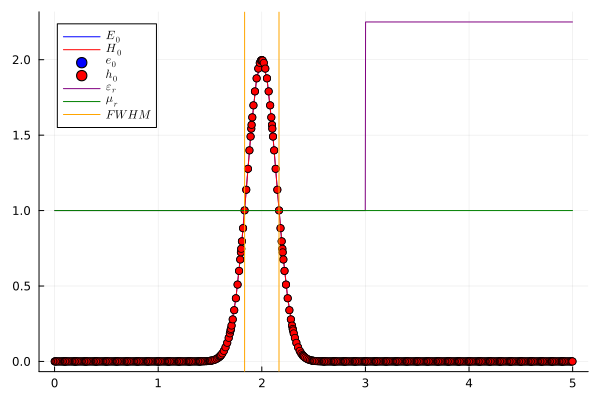

In [59]:
# plot initial analytical conditions and struct's DGSEM initial conditions
# additioally plot how the permitivity and permeability change with position
plot(xx, Eana0, color=:blue,label=L"E_0", format=:png)
plot!(xx, Hana0, color=:red,label=L"H_0", format=:png)
# plot!(xx, p00, color=:orange,label=L"P_{00}", format=:png)

plot!(xreal,dsem.Q[:,1], color=:blue,seriestype=:scatter,label=L"e_0", format=:png)
plot!(xreal,dsem.Q[:,2], color=:red,seriestype=:scatter,label=L"h_0", format=:png)
plot!(xreal, epsr, color=:purple,label=L"\epsilon_r", format=:png)
plot!(xreal, mur, color=:green,label=L"\mu_r", format=:png)
vline!([2.0-0.166], color=:orange, label="")
vline!([2.0+0.166], color=:orange, label=L"FWHM")

In [60]:
#element real location boundaries
xk;

In [61]:
#create elements index locations in 1D array
elindex = zeros(Int64, K*2)
elindex[1] = 1
for k in 1:K-1
    elindex[2*k] = elindex[2*k-1] + N[k]
    elindex[2*k+1] = elindex[2*k]+1
end
elindex[end] = K*(N[end]+1);

In [62]:
# for k in 1:K
#     #left boundary index
#     lpoint = elindex[2*k-1]
#     #right boundary index
#     rpoint = elindex[2*k]
#     println(lpoint,":", rpoint)
# end

In [63]:
#alg 122 for boundary pointers
#create boundary pointers
eleft = append!([-1],[k for k in 1:K])
eright = append!([k for k in 1:K], [-1])
nodeleft = [Ntot for k in 1:K-1]
noderight = [0 for k in 1:K-1];
epk = EPKD(eleft, eright, nodeleft, noderight);

In [64]:
epk.eleft;

In [65]:
epk.eright;

In [66]:
#alg 88 NDG::NDG2DWaves
# ReimannSolver for 1D Maxwell Eqns
function ReimannSolverNDG1DRHMax!(QL::AbstractArray, QR::AbstractArray,  normal::Float64, side::String, epsr::AbstractArray, mur::AbstractArray, c::AbstractArray, Z::AbstractArray)
    #Qout - outgoing corresponds to +
    #Qinc - incoming wave corresponds to -
    #normal is normal to x surface
    #epsr - [1] is incoming eps and [2] is outgoing
    
    ZL = Z[1]
    ZR = Z[2]
    cL = c[1]
    cR = c[2]
    epsL = epsr[1]
    epsR = epsr[2]
    muL = mur[1]
    muR = mur[2]

    EL = QL[1]
    HL = QL[2]
    ER = QR[1]
    HR = QR[2]

    F1 = 0.0
    F2 = 0.0
    
    # FLstar
    if side == "LEFT"
        F1 = normal*( ZR*cL*(EL + ZL*HL) - ZL*cR*(ER - ZR*HR) )/((ZL+ZR)) 
        F2 = normal*(cL*(EL + HL*ZL) + cR*(ER - ZR*HR))/((ZL+ZR))
    elseif side == "RIGHT"
        F1 = -normal*( ZR*cL*(EL + ZL*HL) - ZL*cR*(ER - ZR*HR) )/((ZL+ZR))  
        F2 = -normal*(cL*(EL + HL*ZL) + cR*(ER - ZR*HR))/((ZL+ZR))
    end

    return [F1, F2] #[FLstar1, FLstar2], [FRstar1, Fstar2]
    

end

ReimannSolverNDG1DRHMax! (generic function with 1 method)

In [67]:
#alg 64
#Flux for Maxwell's equations
function FluxMaxwell(F::AbstractArray, Q::AbstractArray, N::Int64, lpoint::Int64, rpoint::Int64, n::AbstractArray, epsr::AbstractArray, mur::AbstractArray)

    F[:,1] = 1.0 ./ epsr .* Q[lpoint:rpoint, 2]#c^2 * Q[lpoint:rpoint, 2]#rhobulk[2] * Q[lpoint:rpoint, 2]
    F[:,2] = 1.0 ./ mur .* Q[lpoint:rpoint, 1]#Q[lpoint:rpoint, 1] #1.0/rhobulk[1] * Q[lpoint:rpoint, 1]

    return nothing #F1, F2

end


FluxMaxwell (generic function with 1 method)

In [68]:
#external function
# ExternalState for open boundaries
function ExtFunFreePropagation(Qint::Array{Float64}, xyBoundary::Float64, xy::Float64, t::Float64, LRTB::String)

    neqn=length(Qint)
    Qext = zeros(Float64, neqn)
    
    if LRTB=="LEFT" #|| LRTB== "RIGHT"
        Qext[1] = 0.0#FeI(xy,t) + FeR(xy,t)#0.0#Fp(xy,t)#Qint[1] #Fp(xy,t)
        Qext[2] = 0.0#FhI(xy,t) + FhR(xy,t)#0.0Fu(xy,t)#-Qint[2] #Fu(xy,t)
        # Qext[3] = Fv(xyBoundary,xy,t)
    elseif LRTB=="RIGHT"
        Qext[1] = 0.0#FeT(xy,t)#Qint[1]#Fp(xy,t) #Fp0(xy,t)
        Qext[2] = 0.0#FhT(xy,t)#-Qint[2]#Fu(xy,t)#Fu0(xy,t)
    end
    return Qext
end

# EI = FeI.(xx,tt)
# HI = FhI.(xx,tt);
# ER = FeR.(xx,tt)
# HR = FhR.(xx,tt);
# ET = FeT.(xx,tt)
# HT = FhT.(xx,tt);

ExtFunFreePropagation (generic function with 1 method)

In [69]:
#CFT Condition
ddxx = 5.0/(Ntot - K)
CFT = 1.0
ddtt = CFT/c1*ddxx


0.018750000000000003

In [71]:
dsema = deepcopy(dsem)
dt = 5.0e-4
ttot = 2.2
NT = floor(Int64, ttot/dt)


4400

In [72]:
tn = 0.0
for n in 0:NT
    if mod(n,100) == 0
        IJulia.clear_output(true)
        println("Time Step: ",n)
    end
    
    @. dsema.G = 0
    @. dsema.dQ = 0

    # DGStepByRK3!(Phi, w, Dhat,g, lp1, ln1, tn, dt, c)
    #ReimannSolverNDG1D
    DGSEMstep1DRK3Max!(dsema, epk, tn, dt, elindex, ExtFunFreePropagation, ReimannSolverNDG1DRHMax!, FluxMaxwell)
    tn = (n+1)*dt
    
    
end

Time Step: 4400


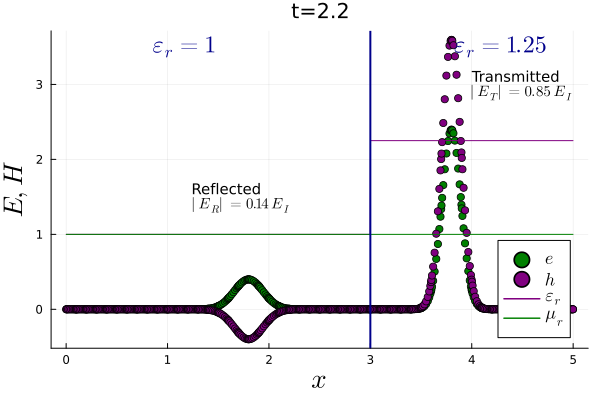

In [75]:
#plot result
plot(xreal,dsema.Q[:,1], color=:green,seriestype=:scatter,label=L"e", format=:png)
plot!(xreal,dsema.Q[:,2], color=:purple,seriestype=:scatter,label=L"h", format=:png)
plot!(title="t=2.2", legend=:bottomright, legendfontsize=12)#, xlim=(3.0,4.0), ylim=(0,1.35))

plot!(xreal, epsr, color=:purple,label=L"\epsilon_r", format=:png)
plot!(xreal, mur, color=:green,label=L"\mu_r", format=:png)
xlabel!(L"x", guidefont=18)
ylabel!(L"E,H", guidefont=18)


Now, let's compare to the solution from Ram et al.

In [78]:
#Ratio of impedence from Griffiths
Beta = Z0/Z1
#Reflected Amplitude
ERef = (1-Beta)/(1+Beta)
#transmitted amplitude
ETran = 2.0/(1+Beta)

0.8

In [81]:
#calculate new pulse widths for reflected and transmitted wave
#and amplitude modifiers
#
taur = tau
ar = 1/pi^0.25 / sqrt(taur)
taut = tau * c1/c0
at = 1/pi^0.25 / sqrt(taut)

tau, taur, taut

(0.1414213562373095, 0.1414213562373095, 0.09428090415820634)

In [82]:
#incident E field
function FeI(x,t)
    FE = 0.0
    if x <= xeps
        FE = a*exp(-((x-X0) - t*speedc(x))^2/(2.0*tau^2))#0.5*( 2^(-((x-X0) - t*speedc(x))^2/b^2) + 2^(-((x-X0) + t*speedc(x))^2/b^2))
    else
        FE=0.0
    end
    return FE
end
#incident H field
function FhI(x,t)
    FH = 0.0
    if x <= xeps
        FH = 1.0/impZ(x) * a*exp(-((x-X0) - t*speedc(x))^2/(2.0*tau^2))#0.5*impZ(x) * (2^(-((x-X0) - speedc(x)*t)^2/b^2) - 2^(-((x-X0) + t*speedc(x))^2/b^2))
    else
        FH=0.0
    end
    return FH
end
#Reflected E field
function FeR(x,t)
    FE = 0.0
    if x <= xeps
        FE = ERef*ar*exp(-((x-(xeps + (xeps-X0))) + t*speedc(x))^2/(2.0*taur^2))#ERef*0.5*( 2^(-((x-(xeps + (xeps-X0))) + t*speedc(x))^2/b^2))
    else
        FE=0.0
    end
    return FE
end
#Reflected H field
function FhR(x,t)
    FH = 0.0
    if x < xeps
        FH = -1.0/impZ(x) * ERef*ar*exp(-((x-(xeps + (xeps-X0))) + t*speedc(x))^2/(2.0*taur^2)) #ERef*0.5*impZ(x) *( 2^(-((x-(xeps + (xeps-X0))) + t*speedc(x))^2/b^2))
    else
        FH=0.0
    end
    return FH
end
#Transfmitted E Field
function FeT(x,t)
    FE = 0.0
    if x >= xeps
        FE = ETran*sqrt(Beta)*at*exp(-( (x-(c1/c0*X0 + (xeps-X0)) ) - t*speedc(x))^2/(2.0*taut^2)) #ETran*0.5*( 2^(-((x-X0) - t*speedc(x))^2/b^2))
    else
        FE=0.0
    end
    return FE
end
#Transmitted H field
function FhT(x,t)
    FH = 0.0
    if x >= xeps
        FH = 1.0/impZ(x) * ETran*sqrt(Beta)*at*exp(-( (x-(c1/c0*X0 + (xeps-X0)) ) - t*speedc(x))^2/(2.0*taut^2)) #ETran*0.5*impZ(x) * (2^(-((x-X0) - speedc(x)*t)^2/b^2))
    else
        FH=0.0
    end
    return FH
end

FhT (generic function with 1 method)

In [83]:
tt = ttot
EI = FeI.(xx,tt)
HI = FhI.(xx,tt);
ER = FeR.(xx,tt)
HR = FhR.(xx,tt);
ET = FeT.(xx,tt)
HT = FhT.(xx,tt);

EE = @. EI+ER+ET
HH = @. HI+HR+HT;

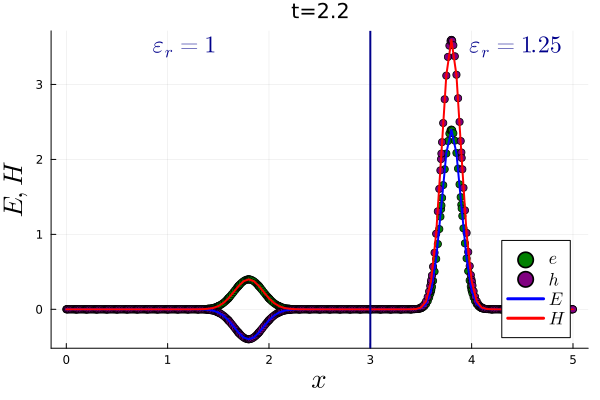

In [87]:
plot(xreal,dsema.Q[:,1], color=:green,seriestype=:scatter,label=L"e", format=:png)
plot!(xreal,dsema.Q[:,2], color=:purple,seriestype=:scatter,label=L"h", format=:png)
plot!(xx, EE, color=:blue,label=L"E", linewidth=2.0,format=:png)
plot!(xx, HH, color=:red,label=L"H", linewidth=2.0,format=:png)
vline!([3], color=:darkblue, linewidth=2, label="")
annotate!(1.5, 3.5, text(L"\epsilon_r = 1", :darkblue, :right, 16))
annotate!(4.9, 3.5, text(L"\epsilon_r = 1.25", :darkblue, :right, 16))
#annotate!(1.3, -0.3, text("Left wave", :black, :right, 10))
# annotate!(1.25, 1.5, text("Reflected\n"*L"|E_R|=0.14 \: E_I", :black, :left, 10))
# annotate!(4.0, 3.0, text("Transmitted\n"*L"|E_T|=0.85 \: E_I", :black, :left, 10))
plot!(title="t=2.2", legend=:bottomright, legendfontsize=12)#, xlim=(1,3))
xlabel!(L"x", guidefont=18)
ylabel!(L"E,H", guidefont=18)

# Conclusion

This concludes our look into the Nodal Discontinuous Galerkin Spectral Element method with discontinuities in the domain. 

In the next notebook, we will look at discontinuities that evolve in time.